# BPL IEC validation

Author: Jan Peter Axelsson

Here I try to reproduce somre results from Jonas Månssons master thesis report "Control of chromatography comlumn in production scale", TFRT-5599.

The interaction withe the model has changed slightly so that linear flow rate LF = F/area is used. The column volume is now specified in terms of (cross-section) area times height. Thus by changing area the scale up works fine and what you do in practice. Further the time unit changed from seconds to minutes.

The model has 5 states as listed below, 3 states in liquid mobile phase and 2 states for the gel for bound proteins. In a few of Jonas figures also bound ions of the buffer are plotted but I do not do that. Bound ions of the buffer can be calculated from the difference of total binding capaciety $Q_{av}$ and bound protein and bound protein antagonist, see section 5.1 in the report.

The molecular weights listed below are not used in the simulations. They just give typical values and the molecular weight for bound protein and antagonist protein is just arbitrary here.

Parameters of the model in general as well as time scale are all arbitrary and focus is on qualitative aspects of the model.

The height of the column is 20 cm which is a common size in the industry.

In [1]:
run -i BPL_IEC_fmpy_explore.py

Windows - run FMU pre-compiled JModelica 2.14

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
 plt.rcParams['figure.figsize'] = [30/2.54, 24/2.54]

No processDiagram.png file in the FMU, but try the file on disk.


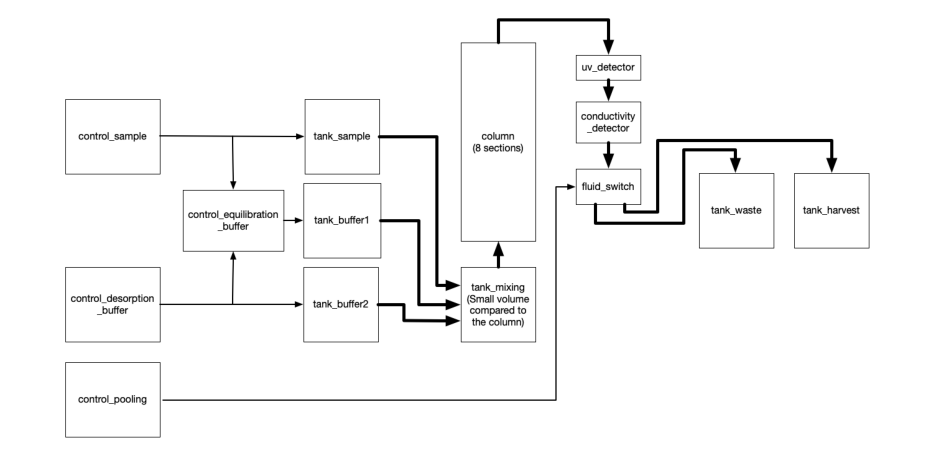

In [3]:
# The process diagram is made outside Modelica to illustrate the configuration
process_diagram()

In [4]:
describe('chromatography'); print(); #describe('liquidphase')

Ion exchange chromatorgraphy controlled with varying salt-concentration. The pH is kept constant.



## Loading or adsorption

The parameter notation and values are the same as in the referred report. However the flow rate is here denoted F while q in the report. The column is diveded in n=8 sections and set at compilation time. The values are arbitrarly chosen in the report and the focus is on qualitative aspects of the model.

The simplified model describe only the column in terms of volume and does not distinguish a high column with a small diameter from a lower with larger diameter.

The parameters k1, k2, k3, k4 and Q_av are given relative volume and with increased column volume a larger capacity is thus obtained.

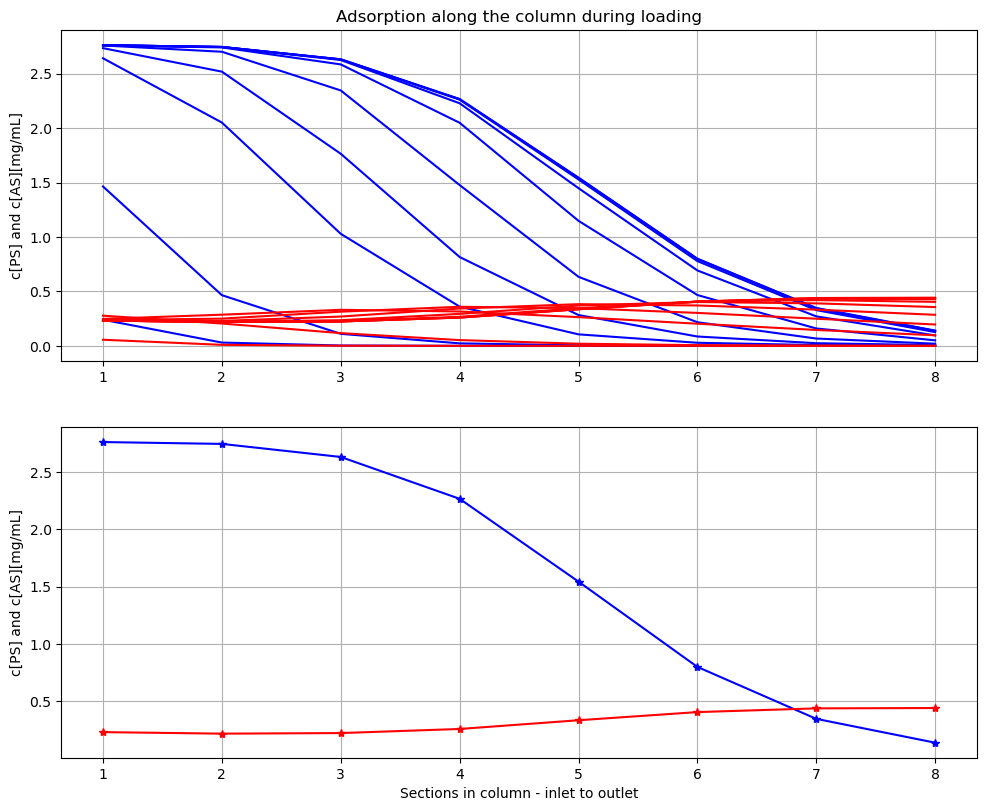

In [5]:
# Loading of the column - try to reproduce Jonas figure 13.
newplot(title='Adsorption along the column during loading', plotType='Loading') 

# Sample
par(P_in=1.0, A_in=1.0, E_in=0)

# Column properties 
par(k1=0.3, k2=0.05, k3=0.05, k4=0.3, Q_av=3.0)
par(height=20, diameter=0.714)
par(x_m=0.3)

# Operation
par(E_in_desorption_buffer=8)
par(LFR=12)
par(scale_volume=False) 
par(start_adsorption=0, stop_adsorption=50)
par(start_desorption=150, stationary_desorption=450)
par(start_pooling=220, stop_pooling=450)

# Simulation
simu(100)

The results are the same af Figure 13 in [1].

In [6]:
# We just check that we had the same volume flow rate as Jonas
describe_general('V', decimals=3)

TypeError: float() argument must be a string or a real number, not 'NoneType'

parLoc = parLocation['V']
par_var = model_description.modelVariables
for k in range(len(par_var)):
   if par_var[k].name == parLoc:
      try:
         if par_var[k].name in start_values.keys():
               value = start_values[par_var[k].name]
         elif par_var[k].variability in ['constant', 'fixed']:        
               value = float(par_var[k].start)     
         elif par_var[k].variability == 'continuous':
            try:
               timeSeries = sim_res[par_var[k].name]
               value = timeSeries[-1]
            except (AttributeError, ValueError):
               value = None
               print('Variable not logged')
         else:
            value = None
      except NameError:
         print('Error: Information available after first simution')
         value = None
print(value)

In [7]:
par_var = model_description.modelVariables

In [8]:
for k in range(50):
    print(par_var[k].name)

BPL.author
BPL.author_address
BPL.author_email
BPL.version
Customer.address
Customer.contact_person
Customer.license_valid_until[1]
Customer.license_valid_until[2]
Customer.license_valid_until[3]
Customer.name
F
MSL.usage
MSL.version
_block_jacobian_check
_block_jacobian_check_tol
_block_solver_experimental_mode
_block_solver_profiling
_cs_experimental_mode
_cs_rel_tol
_cs_solver
_cs_step_size
_enforce_bounds
_events_default_tol
_events_tol_factor
_iteration_variable_scaling
_log_level
_nle_active_bounds_mode
_nle_brent_ignore_error
_nle_jacobian_calculation_mode
_nle_jacobian_finite_difference_delta
_nle_jacobian_update_mode
_nle_solver_check_jac_cond
_nle_solver_default_tol
_nle_solver_exit_criterion
_nle_solver_max_iter
_nle_solver_max_iter_no_jacobian
_nle_solver_max_residual_scaling_factor
_nle_solver_min_residual_scaling_factor
_nle_solver_min_tol
_nle_solver_regularization_tolerance
_nle_solver_step_limit_factor
_nle_solver_tol_factor
_nle_solver_use_last_integrator_step
_nle_so

In [9]:
model_get('column.x_m')

0.3

In [10]:
model_get('column.V_m')

TypeError: float() argument must be a string or a real number, not 'NoneType'

In [11]:
describe('column.n')

Number of sections of the column : 8.0 [ None ]


In [12]:
model_get('column.column_section[1].V_m')

TypeError: float() argument must be a string or a real number, not 'NoneType'

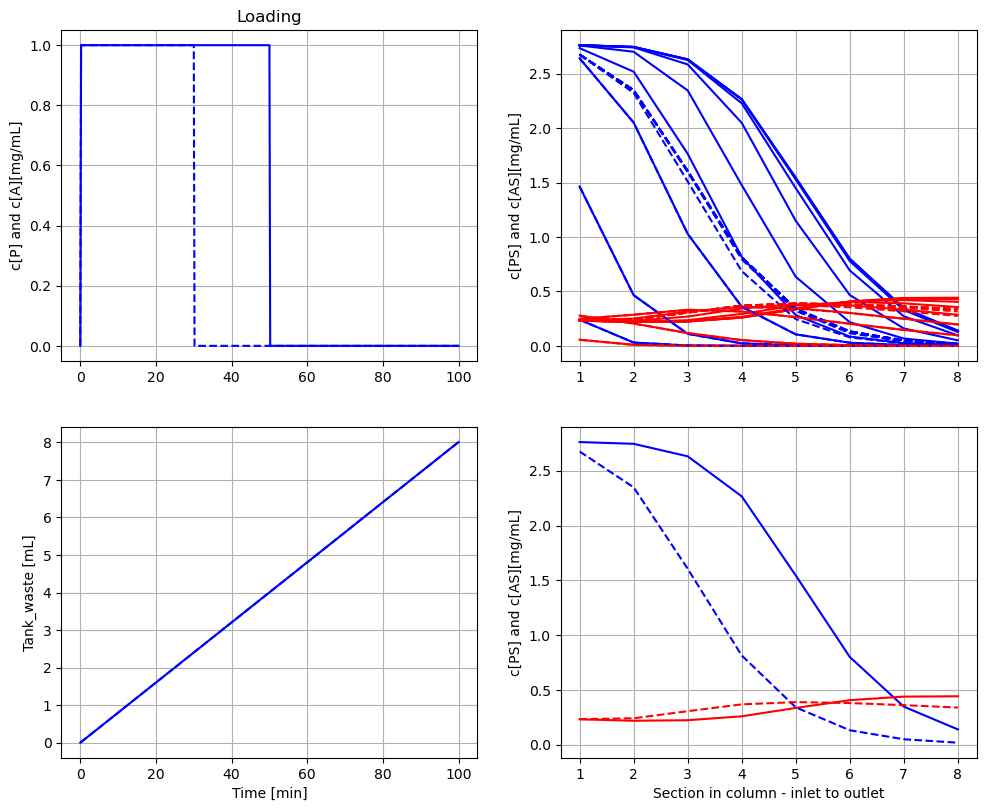

In [13]:
# Impact of shorter time for loading and then less material
newplot(title='Loading', plotType='Loading-combined')
show()

# Simulation with changed parameter t2
par(stop_adsorption=30); simu(100)

# Reset changed parameter
par(stop_adsorption=50)

To the left the inlet loading over time. 
To the right upper concentration along the column at different times and in steady states finally
To the right lower concentrations along the colunn in steady state.

We see that a shorter time and then less material makes less of the column capacity used.

Note that the flow through the column is constant despite change from sample to just buffer 1, and shown in how the volume of the waste tank increase with time.

## Elution or desorption

TypeError: float() argument must be a string or a real number, not 'NoneType'

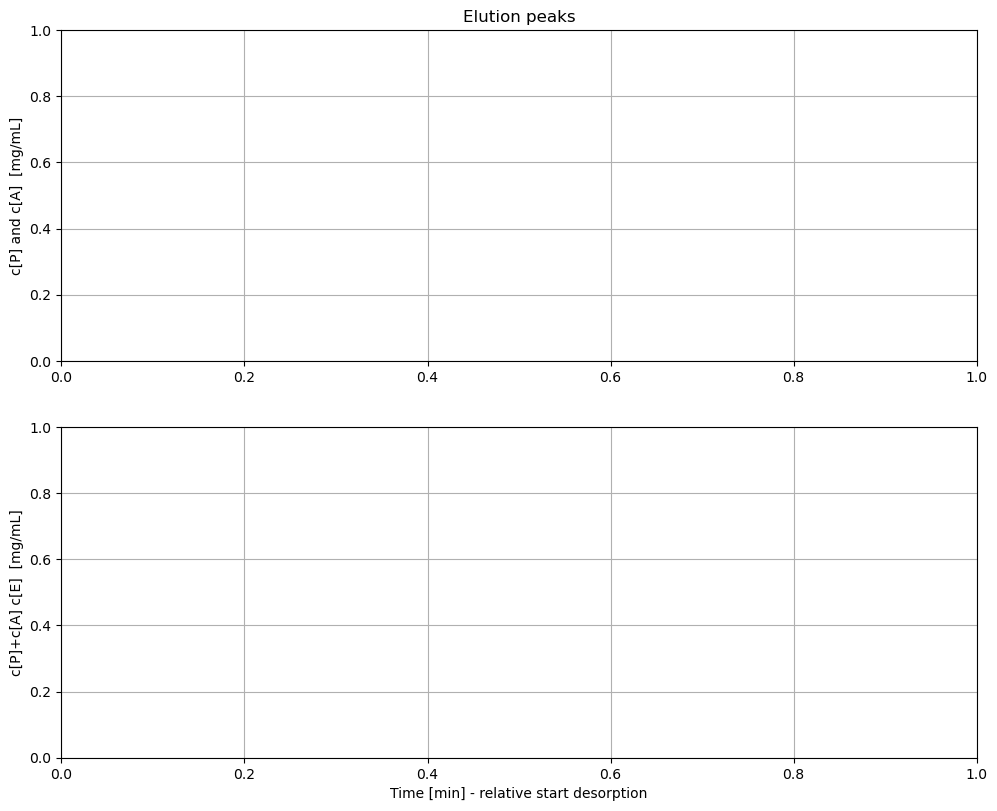

In [14]:
# Elution of the column
newplot(title='Elution peaks', plotType='Elution')

# Sample
par(P_in=1, A_in=1.0, E_in=0)

# Operation
par(E_in_desorption_buffer=8)
par(LFR=12.0, start_adsorption=0, stop_adsorption=50, start_desorption=150, stationary_desorption=450)

# Simulation
simu(550)

The results are the same af Figure 14 in [1].

The upper diagrams shows the column outlet concentrations of P and A over time.

The lower diagram shows the sum (or possibly the UV signal) at column outlet as well as the salt concentration. We have some separation between the two peaks.

Note that the salt concentration deviates slightly from the linear increse between time 50 to 100. This is due to ion interaction with P and A in the column. This is phenomenon can also be seen in real data.
The ion-salt concentration is scaled with factor 0.05 to get comparable concentrations to P and A.

I have here simulated time 150 of adsorbtion and then started elution. Here is time counted as zero at time of start of elutions. Not sure how long Jonas simulated to get steady state before he did elution.

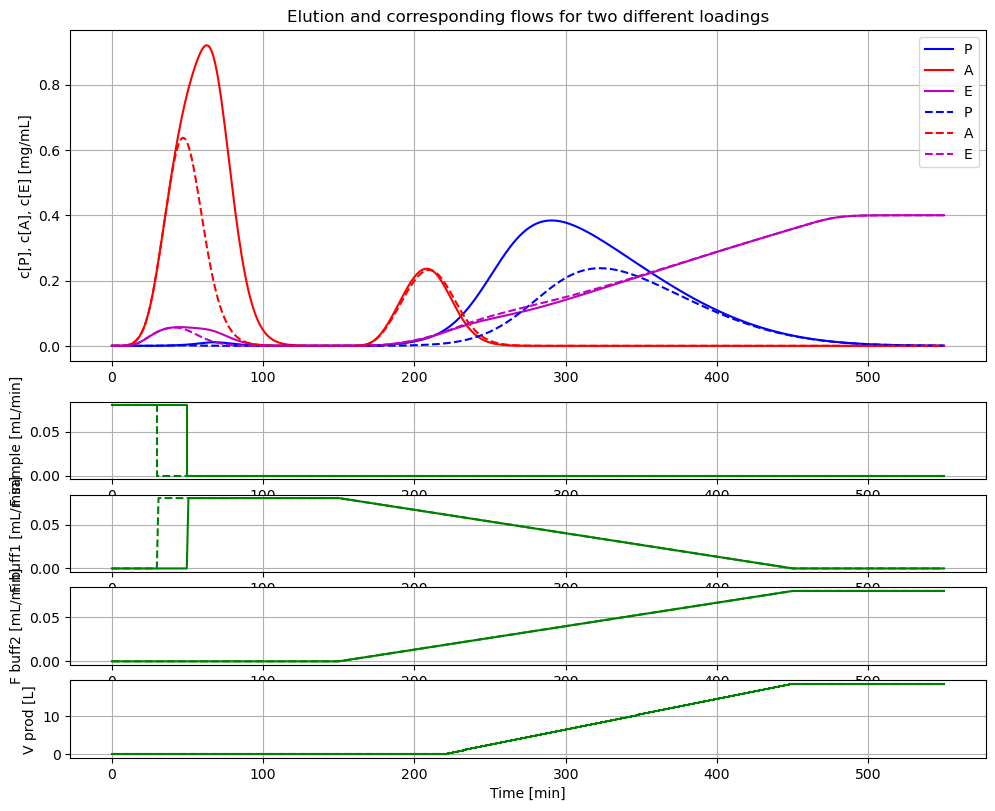

In [15]:
# More complete visualization of the elution phase and the different flows
newplot(title='Elution and corresponding flows for two different loadings', plotType='Elution-combined')
par(stop_adsorption=50); simu(550)

# Simulation with changed parameter t2
par(stop_adsorption=30); simu(550)

# Reset changed parameter
par(stop_adsorption=50)

Here a diagram that shows the peaks at the outlet as shown in the previous diagram. Below the flow rates of the three differnet sorces. Here time is 0 at start of adsorbtion and elution starts at time 150.

Automatic pooling based on UV-mmeasurement is tested in another notebook.

## Change of resin properties

TypeError: float() argument must be a string or a real number, not 'NoneType'

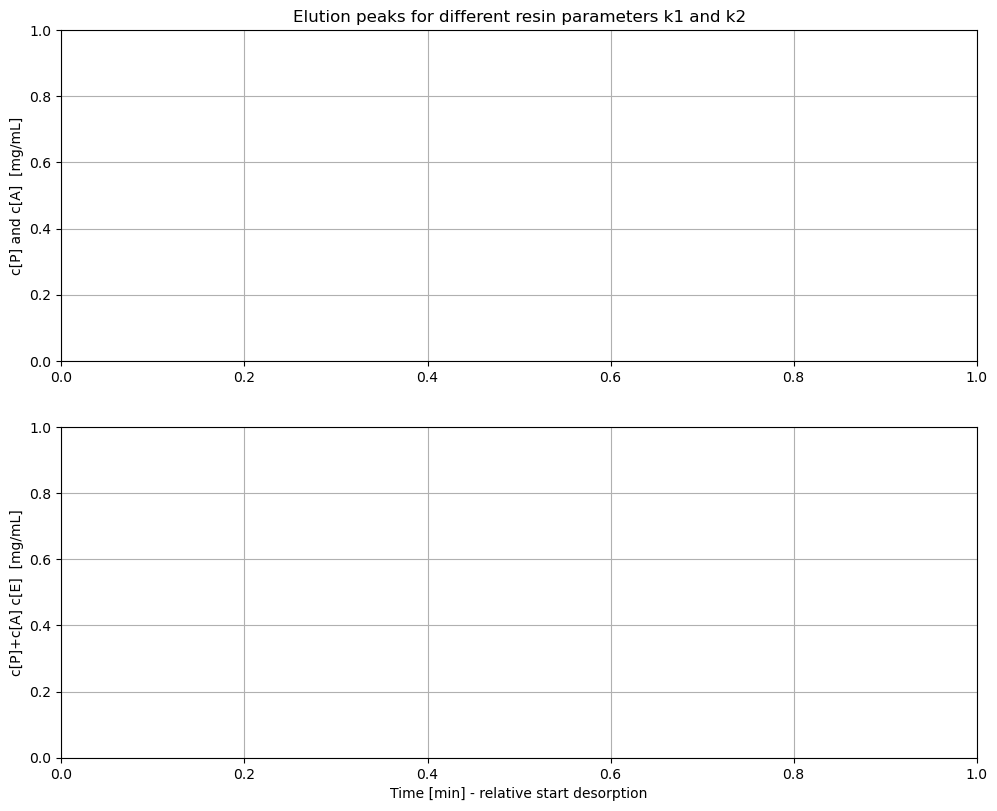

In [16]:
# Elution of the column
newplot(title='Elution peaks for different resin parameters k1 and k2', plotType='Elution')

# Sample
par(P_in=1, A_in=0.0, E_in=0)

# Operation
par(E_in_desorption_buffer=8)
par(LFR=12.0, start_adsorption=0, stop_adsorption=50, start_desorption=150, stationary_desorption=450)

# Simulations
par(k1=0.05, k2=0.50); simu(550)
par(k1=0.05, k2=0.25); simu(550)
par(k1=0.05, k2=0.05); simu(550)
par(k1=0.25, k2=0.05); simu(550)
par(k1=0.50, k2=0.05); simu(550)

# Adjust diagrams
ax1.set_ylim([0, 0.65])
ax2.set_ylim([0, 0.65])
plt.show()

The results are the same af Figure 17 in [1].

## Summary
Three important diagrams Figure 13, 14 and 17 in the original report [1] were reproduced and the implementation in Modelica used here is considered validated.

The model is now extended with an improved parametrization of the column that match the industrial practice.

## Acknowledgement

The author thank Karl Johan Brink for sharing his know-how of chromatography operation. 
He has especially given input to how to parametrize the model in terms often used in the industrial practice.

## References

1) Månsson, Jonas, "Control of chromatography comlumn in production scale", Master thesis TFRT-5599, Department of Automatic Control, LTH, Lund Sweden, 1998.

2) Pharmacia LKB Biotechnology. "Ion Exchange chromatography. Principles and Methods.", 3rd edition, 1991.
3) Jungbauer, Alois and Giorgio Carta, "Protein Chromatography: Process Development
and Scale-Up", Wiley 2nd edition, 2020.

## Appendix

In [17]:
describe('MSL')

MSL: RealInput, RealOutput, Constants, Hysteresis, CombiTimeTable, Types


In [18]:
system_info()


System information
 -OS: Windows
 -Python: 3.12.3
 -Scipy: not installed in the notebook
 -FMPy: 0.3.20
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: CS
 -Name: BPL_IEC.Column_system
 -Generated: 2024-05-13T18:30:38
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.2.0
 -Interaction: FMU-explore for FMPy version 1.0.0
